In [4]:
import numpy as np
import re
import scipy.stats as stats
import math
import time

vocab = set()
docs = []

D = 472 # number of documents
K = 10 # number of topics

# open each file; convert everything to lowercase and strip non-letter symbols; split into words
for fileind in range( 1, D+1 ):
    foo = open( 'data/genconf/output%04d.txt' % fileind ).read()    
    tmp = re.sub( '[^a-z ]+', ' ', foo.lower() ).split()
    docs.append( tmp )

    for w in tmp:
        vocab.add( w )

# vocab now has unique words
# give each word in the vocab a unique id
vhash = {}
vindhash = {}
for ind, i in enumerate(list(vocab)):
    vhash[i] = ind
    vindhash[ind] = i

# size of our vocabulary
V = len(vocab)

# reprocess each document and re-represent it as a list of word ids
docs_i = [[vhash[w] for w in d] for d in docs]

alphas = np.ones((K,1))[:,0]
gammas = np.ones((V,1))[:,0]

In [5]:
qs = [np.random.choice(range(K), size=(len(docs_i[d]))) for d in range(D)]
civk = np.zeros((D, V, K))
for d in range(D):
    for l in range(len(docs_i[d])):
        civk[d, docs_i[d][l], qs[d][l]] += 1

cvk = np.sum(civk, axis=0)
cik = np.sum(civk, axis=1)
ck = np.sum(cvk, axis=0)

In [7]:
# gibbs sampling
for iters in range(0,100):
    start_time = time.time()

    # resample per-word topic assignments bs (K, V)
    bs = np.zeros((K, V))
    tmp = gammas + cvk.T
    for k in range(K):
        bs[k] = np.random.dirichlet(tmp[k])

    # resample topics (D, K) and per-document topic mixtures pis (D, K)
    prob = 0
    tmp = alphas + cik
    for d in range(D):
        # resample topic mixture for document d
        pis =  np.random.dirichlet(tmp[d])
        for l, word in enumerate(docs_i[d]):
            theta = pis * bs[:, word]
            prob += math.log(theta[qs[d][l]])
            theta /= np.sum(theta)

            civk[d][word][qs[d][l]] -= 1
            cvk[word][qs[d][l]] -= 1
            cik[d][qs[d][l]] -= 1
            ck[qs[d][l]] -= 1
            # resample topic of word l in document d
            qs[d][l] = np.random.choice(range(K), size=(1), p=(theta))
            ck[qs[d][l]] += 1
            cik[d][qs[d][l]] += 1
            cvk[word][qs[d][l]] += 1
            civk[d][word][qs[d][l]] += 1

    print 'time: %f'%(time.time() - start_time)
    print("Iter %d, prob=%.2f" % (iters,prob))

time: 48.092106
Iter 0, prob=-7249925.84
time: 47.486787
Iter 1, prob=-7220302.06
time: 47.694473
Iter 2, prob=-7200427.15
time: 46.853507
Iter 3, prob=-7184821.70
time: 46.736776
Iter 4, prob=-7172871.20
time: 48.156197
Iter 5, prob=-7161426.74
time: 47.013648
Iter 6, prob=-7152194.09
time: 46.728321
Iter 7, prob=-7142253.48
time: 46.963864
Iter 8, prob=-7133541.75
time: 48.332519
Iter 9, prob=-7123093.45


KeyboardInterrupt: 

In [8]:
qs = [np.random.choice(range(K), size=(len(docs_i[d]))) for d in range(D)]
civk = np.zeros((D, V, K))
for d in range(D):
    for l in range(len(docs_i[d])):
        civk[d, docs_i[d][l], qs[d][l]] += 1

cvk = np.sum(civk, axis=0)
cik = np.sum(civk, axis=1)
ck = np.sum(cvk, axis=0)
Li = np.sum(civk, axis=(1,2))

In [9]:
# collapsed gibbs sampling
for iters in range(0,100):
    start_time = time.time()
    prob = 0
    for d in range(D):
        for l, word in enumerate(docs_i[d]):
            civk[d][word][qs[d][l]] -= 1
            cvk[word][qs[d][l]] -= 1
            cik[d][qs[d][l]] -= 1
            ck[qs[d][l]] -= 1

            prob += ((cvk[word][qs[d][l]] + gammas[0]) / (ck[qs[d][l]] + V*gammas[0])) * ((cik[d][qs[d][l]] + alphas[0]) / (Li[d] + K*alphas[0]))
            pk = ((cvk[word] + gammas[0]) / (ck + V*gammas[0])) * ((cik[d] + alphas[0]) / (Li[d] + K*alphas[0]))
            pk /= np.sum(pk)
            nt = np.random.choice(range(K), size=(1), p=(pk))
            qs[d][l] = nt

            ck[qs[d][l]] += 1
            cik[d][qs[d][l]] += 1
            cvk[word][qs[d][l]] += 1
            civk[d][word][qs[d][l]] += 1

    print 'time: %f'%(time.time() - start_time)
    print("Iter %d, prob=%.2f" % (iters,prob))

time: 55.959937
Iter 0, prob=700.55
time: 51.936447
Iter 1, prob=715.11
time: 52.619832
Iter 2, prob=732.80
time: 51.297599
Iter 3, prob=751.93
time: 52.293433
Iter 4, prob=770.08
time: 48.307231
Iter 5, prob=791.15
time: 47.780721
Iter 6, prob=815.66
time: 48.183577
Iter 7, prob=846.02


KeyboardInterrupt: 

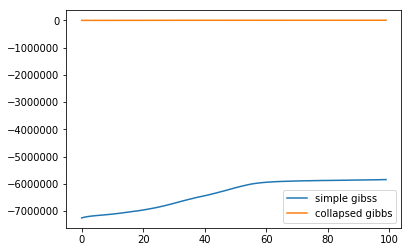

In [29]:
import pickle
import matplotlib.pyplot as plt

with open ('simple_probs', 'rb') as fp:
    simple_probs = pickle.load(fp)

with open ('collapsed_probs.txt', 'rb') as fp:
    collapsed_probs = pickle.load(fp)

plt.plot(simple_probs, label='simple gibss')
plt.plot(collapsed_probs, label='collapsed gibbs')
plt.legend()
plt.show()

[[  2.   1.  32. ...,  16.  15.   2.]
 [  0.   6.   0. ...,   0.   0.   2.]
 [  1.   1.   5. ...,   0.   4.   5.]
 ..., 
 [  0.   0.   0. ...,   0.   1.   0.]
 [  1.   1.   0. ...,   0.   0.   0.]
 [  1.   1.   0. ...,   2.   0.   1.]]
[[  2.   1.  32. ...,  16.  15.   2.]
 [  0.   6.   0. ...,   0.   0.   2.]
 [  1.   1.   5. ...,   0.   4.   5.]
 ..., 
 [  0.   0.   0. ...,   0.   1.   0.]
 [  1.   1.   0. ...,   0.   0.   0.]
 [  1.   1.   0. ...,   2.   0.   1.]]


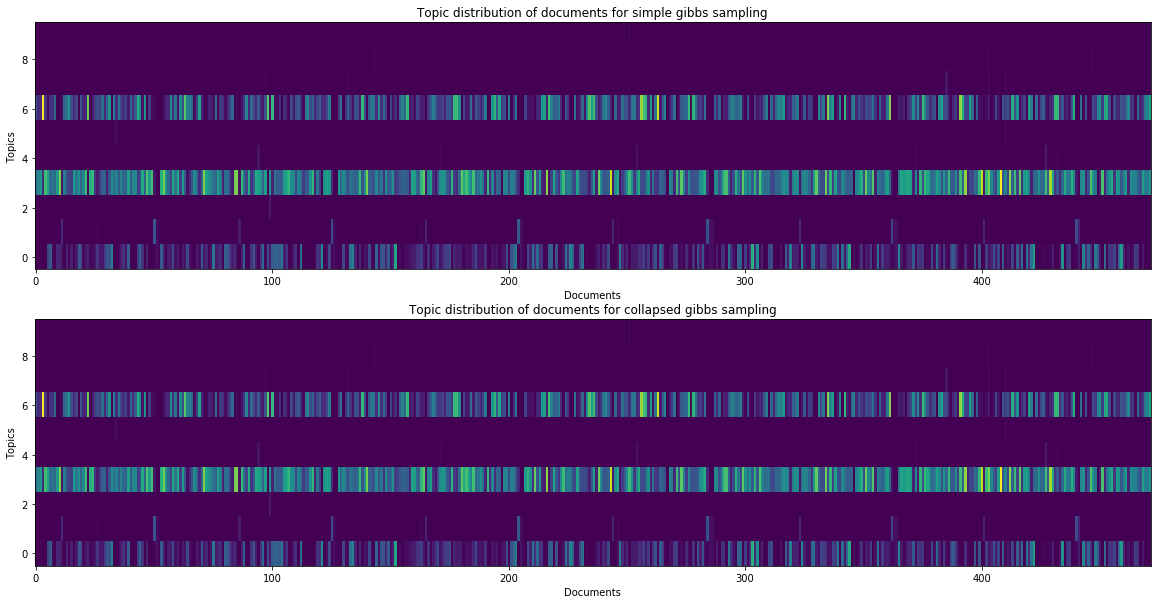

In [30]:
with open ('simple_qs', 'rb') as fp:
    simple_qs = pickle.load(fp)

with open ('collapsed_qs.txt', 'rb') as fp:
    collapsed_qs = pickle.load(fp)

simp = np.zeros((D, K))
coll = np.zeros((D, K))
for d in range(D):
    for l, word in enumerate(docs_i[d]):
        simp[d, simple_qs[d][l]] += 1
        coll[d, simple_qs[d][l]] += 1

print simp.T
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].set_title('Topic distribution of documents for simple gibbs sampling')
axs[0].set_xlabel('Documents')
axs[0].set_ylabel('Topics')
axs[0].imshow( simp.T, aspect='auto' )
axs[0].invert_yaxis()

print coll.T
axs[1].set_title('Topic distribution of documents for collapsed gibbs sampling')
axs[1].set_xlabel('Documents')
axs[1].set_ylabel('Topics')
axs[1].imshow( coll.T, aspect='auto' )
axs[1].invert_yaxis()
plt.show()

[[ 1.  1.  7. ...,  1.  5.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 1.  1.  7. ...,  1.  5.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


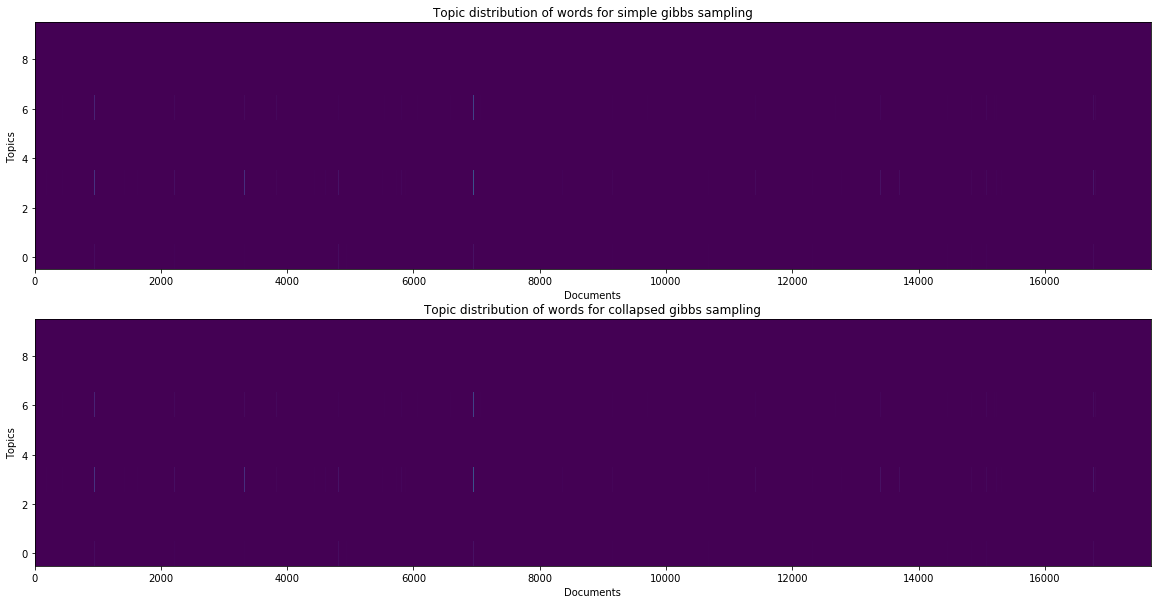

In [31]:
simp = np.zeros((V, K))
coll = np.zeros((V, K))
for d in range(D):
    for l, word in enumerate(docs_i[d]):
        simp[word, simple_qs[d][l]] += 1
        coll[word, simple_qs[d][l]] += 1

print simp.T
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].set_title('Topic distribution of words for simple gibbs sampling')
axs[0].set_xlabel('Documents')
axs[0].set_ylabel('Topics')
axs[0].imshow( simp.T, aspect='auto' )
axs[0].invert_yaxis()

print coll.T
axs[1].set_title('Topic distribution of words for collapsed gibbs sampling')
axs[1].set_xlabel('Documents')
axs[1].set_ylabel('Topics')
axs[1].imshow( coll.T, aspect='auto' )
axs[1].invert_yaxis()
plt.show()